In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [2]:
print("torch version: ", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")

print("device: ", device)

torch version:  2.6.0
device:  mps


# Camera / Dataset

In [7]:
batch_size = 1024

o, d, target_px_values = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

# Training

In [ ]:
device = device

tn = 8.
tf = 12.
nb_epochs = 8
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'nerf_model_weights.pth')


# Testing

In [8]:
test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

In [9]:
device = device
tn = 8.
tf = 12.

In [12]:
import torch
from model import Nerf  # Import your Nerf class

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model = Nerf(hidden_dim=128).to(device)  # Initialize with the same architecture as before
model.load_state_dict(torch.load('nerf_model_weights.pth'))
model.eval()  # Set to evaluation mode if you're going to use it for inference

Nerf(
  (block1): Sequential(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=191, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=129, bias=True)
  )
  (rgb_head): Sequential(
    (0): Linear(in_features=155, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Sigmoid()
  )
)

In [13]:
def mse2psnr(mse):
    return 20 * np.log10(1 / np.sqrt(mse))


@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):
    
    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)
    
    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()
    
    if target is not None:
        mse = ((image - target)**2).mean()
        psnr = mse2psnr(mse)
    
    if target is not None: 
        return image, mse, psnr
    else:
        return image

In [14]:
# First convert numpy arrays to float32
test_o_float32 = test_o[0].astype(np.float32)
test_d_float32 = test_d[0].astype(np.float32)
test_target_float32 = test_target_px_values[0].reshape(400, 400, 3).astype(np.float32)

# Then convert to tensors and move to device
test_o_tensor = torch.from_numpy(test_o_float32).to(device)
test_d_tensor = torch.from_numpy(test_d_float32).to(device)
target_tensor = torch.from_numpy(test_target_float32).to(device)

# Run the test function
img, mse, psnr = test(
    model,
    test_o_tensor,
    test_d_tensor,
    tn, tf,
    nb_bins=100,
    chunk_size=10,
    target=target_tensor.cpu().numpy()  # Convert to numpy here if test() expects numpy
)
print(psnr)

32.883553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06044662..1.0000002].


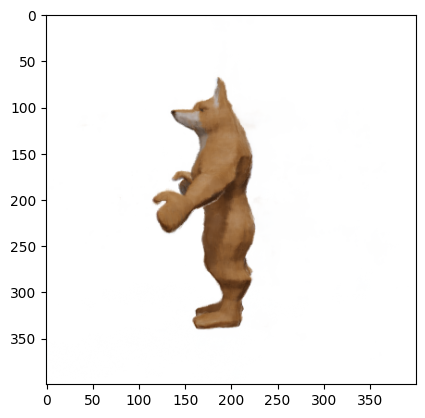

In [15]:
plt.imshow(img)

In [21]:
import torch
import numpy as np
from nerfvis import scene
from model import Nerf

# Define device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Initialize the model with the same architecture as your training
model = Nerf(hidden_dim=128).to(device)

# Load the saved weights
model.load_state_dict(torch.load('nerf_model_weights.pth', map_location=device))
model.eval()

# Create a scene
scene.set_title("NeRF Visualization")

# Add coordinate axes for reference
scene.add_axes("axes", length=1.0)

# Define a 3D grid of points to sample your NeRF
resolution = 64  # Number of points per dimension
x = np.linspace(-2, 2, resolution)
y = np.linspace(-2, 2, resolution)
z = np.linspace(-2, 2, resolution)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
points = np.stack([xx.flatten(), yy.flatten(), zz.flatten()], axis=-1)

# For each point, we'll use multiple viewing directions
num_directions = 6
directions = []
for i in range(num_directions):
    # Create evenly distributed viewing directions
    theta = np.pi * i / num_directions
    phi = 2 * np.pi * i / num_directions
    dx = np.sin(theta) * np.cos(phi)
    dy = np.sin(theta) * np.sin(phi)
    dz = np.cos(theta)
    directions.append([dx, dy, dz])

directions = np.array(directions)
directions_tensor = torch.tensor(directions, dtype=torch.float32, device=device)

# Evaluate NeRF at these points and directions
print("Evaluating NeRF at grid points...")
valid_points = []
valid_colors = []

batch_size = 5000
num_batches = (points.shape[0] + batch_size - 1) // batch_size

# Density threshold
threshold = 0.5  # Adjust as needed

with torch.no_grad():
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, points.shape[0])
        batch_points = torch.tensor(points[start_idx:end_idx], dtype=torch.float32, device=device)
        
        batch_colors_list = []
        batch_densities_list = []
        
        for direction in directions_tensor:
            # Expand direction to match the batch size
            batch_dirs = direction.expand(batch_points.size(0), -1)
            
            # Get model output
            output = model(batch_points, batch_dirs)
            
            # Store results
            if isinstance(output, tuple):
                rgb, sigma = output
            else:
                # If output is a single tensor with RGB and density concatenated
                rgb = output[:, :3]
                sigma = output[:, 3:4]
            
            batch_colors_list.append(rgb)
            batch_densities_list.append(sigma)
        
        # Average colors across different view directions
        avg_colors = torch.stack(batch_colors_list).mean(dim=0)
        # Use maximum density across different view directions
        max_densities = torch.stack(batch_densities_list).max(dim=0)[0]
        
        # Apply activation to densities (if needed)
        density_vals = torch.sigmoid(max_densities).flatten()
        
        # Find points above threshold
        batch_valid_indices = torch.where(density_vals > threshold)[0].cpu().numpy()
        
        if len(batch_valid_indices) > 0:
            # Get valid points and colors for this batch
            batch_valid_points = points[start_idx:end_idx][batch_valid_indices]
            batch_valid_colors = avg_colors[batch_valid_indices].cpu().numpy()
            
            # Make sure colors are in valid range [0,1]
            batch_valid_colors = np.clip(batch_valid_colors, 0, 1)
            
            # Append to our valid points and colors
            valid_points.append(batch_valid_points)
            valid_colors.append(batch_valid_colors)
            
        print(f"Processed batch {i+1}/{num_batches} - Found {len(batch_valid_indices)} valid points")

# Combine all valid points and colors
if valid_points:
    all_valid_points = np.vstack(valid_points)
    all_valid_colors = np.vstack(valid_colors)
    
    print(f"Total valid points: {len(all_valid_points)}")
    
    # Visualize the points
    scene.add_points(
        name="nerf_high_density",
        points=all_valid_points,
        vert_color=all_valid_colors,
        point_size=2.0
    )
else:
    print("No high-density points found. Try lowering the threshold.")
    
# Add some reference objects
scene.add_wireframe_cube("bounds", scale=4.0, color=[0.5, 0.5, 0.5])

# Display the scene
scene.display(port=8888, open_browser=True)

Using device: mps
Evaluating NeRF at grid points...
Processed batch 1/53 - Found 0 valid points
Processed batch 2/53 - Found 0 valid points
Processed batch 3/53 - Found 0 valid points
Processed batch 4/53 - Found 8 valid points
Processed batch 5/53 - Found 0 valid points
Processed batch 6/53 - Found 1 valid points
Processed batch 7/53 - Found 0 valid points
Processed batch 8/53 - Found 1 valid points
Processed batch 9/53 - Found 0 valid points
Processed batch 10/53 - Found 0 valid points
Processed batch 11/53 - Found 0 valid points
Processed batch 12/53 - Found 0 valid points
Processed batch 13/53 - Found 0 valid points
Processed batch 14/53 - Found 3 valid points
Processed batch 15/53 - Found 4 valid points
Processed batch 16/53 - Found 7 valid points
Processed batch 17/53 - Found 22 valid points
Processed batch 18/53 - Found 16 valid points
Processed batch 19/53 - Found 37 valid points
Processed batch 20/53 - Found 52 valid points
Processed batch 21/53 - Found 86 valid points
Process

127.0.0.1 - - [06/Mar/2025 16:46:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Mar/2025 16:46:39] code 404, message File not found
127.0.0.1 - - [06/Mar/2025 16:46:39] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [06/Mar/2025 16:46:39] "GET /volrend.draw.npz HTTP/1.1" 200 -


nervfvis-server interrupted


('nerfvis_scenes/NeRFVisualization', 'http://localhost:8888')

In [ ]:
!pip install nerfvis
!pip install scipy

Rendering views:   0%|          | 0/8 [00:00<?, ?it/s]

Rendering views: 100%|██████████| 8/8 [00:09<00:00,  1.19s/it]
/Users/jorgemuyo/miniforge3/envs/NeRF/lib/python3.13/site-packages/nerfvis/scene.py:74: UserWarning: Expected vectorized input but this is inconsistent with given translation with 1 dimensions. We will fix all the shapes, but relying on this is not recommended.
  warnings.warn(f"Expected {vec_str} input but this is inconsistent with "


Serving localhost:8888


127.0.0.1 - - [06/Mar/2025 16:23:46] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Mar/2025 16:23:47] "GET /volrend.draw.npz HTTP/1.1" 200 -
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06044662..1.0000002].


nervfvis-server interrupted


ValueError: num must be an integer with 1 <= num <= 8, not 9

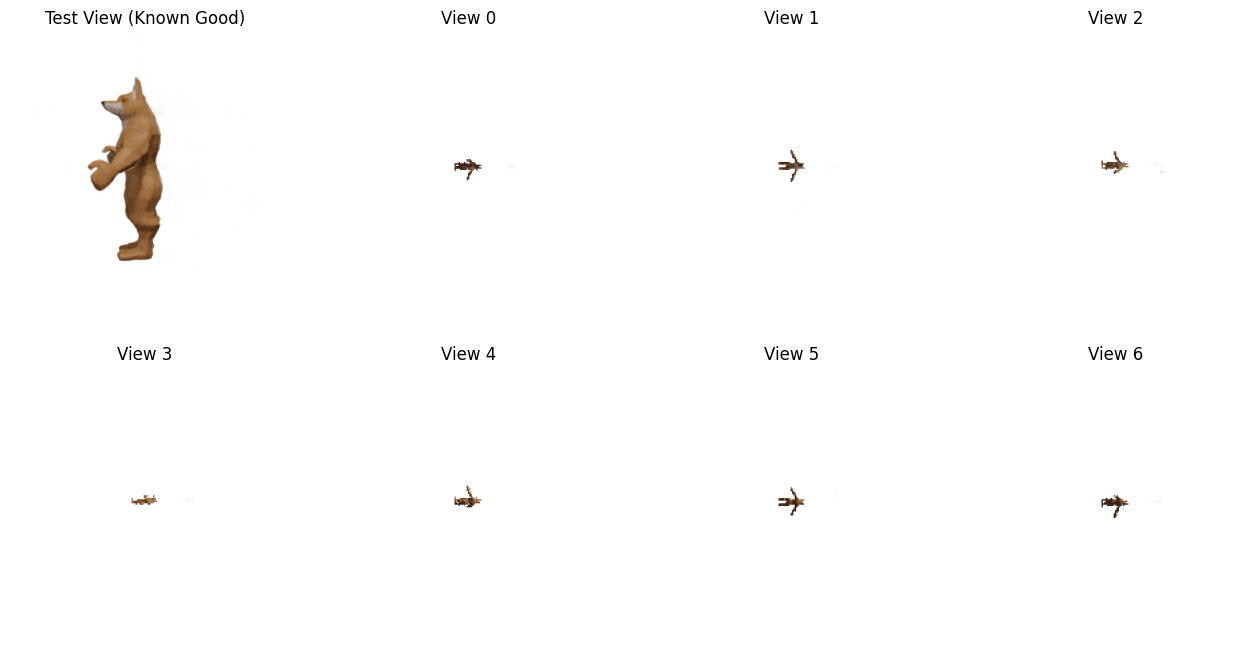

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from nerfvis import Scene
from tqdm import tqdm

# Make sure model is in evaluation mode
model.eval()

@torch.no_grad()
def render_views(model, radius=10.0, n_views=6, resolution=100, tn=8.0, tf=12.0, nb_bins=100):
    """Render multiple views of the NeRF by rotating the camera around it"""
    views = []
    
    # Create camera positions on a circle around the object
    angles = np.linspace(0, 2*np.pi, n_views, endpoint=False)
    
    for i, angle in enumerate(tqdm(angles, desc="Rendering views")):
        # Calculate camera position on a circle
        cam_x = radius * np.cos(angle)
        cam_y = radius * np.sin(angle)
        cam_z = 0.0  # Keep camera at same height
        
        # Camera position (origin in NeRF coordinates)
        origin = np.array([cam_x, cam_y, cam_z], dtype=np.float32)
        
        # Look-at point (center of the scene)
        look_at = np.array([0.0, 0.0, 0.0], dtype=np.float32)
        
        # Camera orientation
        forward = look_at - origin
        forward = forward / np.linalg.norm(forward)
        
        # Define up vector 
        up = np.array([0.0, 0.0, 1.0], dtype=np.float32)
        
        # Get camera basis vectors
        right = np.cross(forward, up)
        right = right / np.linalg.norm(right)
        
        true_up = np.cross(right, forward)
        true_up = true_up / np.linalg.norm(true_up)
        
        # Create pixel grid
        i, j = np.meshgrid(
            np.linspace(-1, 1, resolution),
            np.linspace(-1, 1, resolution),
            indexing='ij'
        )
        
        # Create origins and directions for each pixel
        origins = np.tile(origin, (resolution*resolution, 1))
        
        # Create ray directions for each pixel
        directions = np.stack([
            i.flatten() * right[0] + j.flatten() * true_up[0] + forward[0],
            i.flatten() * right[1] + j.flatten() * true_up[1] + forward[1],
            i.flatten() * right[2] + j.flatten() * true_up[2] + forward[2],
        ], axis=-1)
        
        # Normalize directions
        directions = directions / np.linalg.norm(directions, axis=1, keepdims=True)
        
        # Convert to tensors
        origins_tensor = torch.from_numpy(origins).float().to(device)
        directions_tensor = torch.from_numpy(directions).float().to(device)
        
        # Render the view using the rendering function
        # Process in chunks to avoid memory issues
        chunk_size = 1024
        o_chunks = torch.split(origins_tensor, chunk_size)
        d_chunks = torch.split(directions_tensor, chunk_size)
        
        rendered_chunks = []
        for o_chunk, d_chunk in zip(o_chunks, d_chunks):
            # Use your existing rendering function
            rendered_chunk = rendering(model, o_chunk, d_chunk, tn, tf, nb_bins=nb_bins, device=device)
            rendered_chunks.append(rendered_chunk)
        
        rendered_view = torch.cat(rendered_chunks)
        rendered_view = rendered_view.reshape(resolution, resolution, 3).cpu().numpy()
        
        # Clip values to be in range [0, 1]
        rendered_view = np.clip(rendered_view, 0.0, 1.0)
        
        views.append(rendered_view)
        
    return views

# Render multiple views of the NeRF
n_views = 8
resolution = 200
views = render_views(model, radius=10.0, n_views=n_views, resolution=resolution, tn=tn, tf=tf, nb_bins=100)

# Create a visualization with nerfvis
scene = Scene()
scene.set_title("Fox NeRF Multi-View Visualization")

# Add the rendered views as images in a circle around the origin
radius = 5.0
angles = np.linspace(0, 2*np.pi, n_views, endpoint=False)

for i, (view, angle) in enumerate(zip(views, angles)):
    # Calculate position
    pos_x = radius * np.cos(angle)
    pos_y = radius * np.sin(angle)
    pos_z = 0.0
    
    # Calculate rotation matrix (looking at the origin)
    forward = np.array([-pos_x, -pos_y, -pos_z])
    forward = forward / (np.linalg.norm(forward) + 1e-10)
    
    up = np.array([0.0, 0.0, 1.0])
    
    right = np.cross(forward, up)
    right = right / (np.linalg.norm(right) + 1e-10)
    
    true_up = np.cross(right, forward)
    true_up = true_up / (np.linalg.norm(true_up) + 1e-10)
    
    # Construct rotation matrix
    r = np.stack([right, true_up, -forward], axis=1)
    
    # Add the image to the scene with increased visibility and size
    scene.add_image(
        f"view_{i}",
        view,
        r=r,
        t=np.array([pos_x, pos_y, pos_z]),
        focal_length=resolution,  # Larger focal length for bigger images
        z=1.0,  # Increased size
        visible=True  # Explicitly set to visible
    )

# Add navigational helpers to easily jump to specific views
for i, angle in enumerate(angles):
    pos_x = radius * np.cos(angle)
    pos_y = radius * np.sin(angle)
    pos_z = 0.0
    
    # Add a camera frustum to show the camera position and orientation
    scene.add_camera_frustum(
        f"camera_{i}",
        r=np.stack([right, true_up, -forward], axis=1),  # Same rotation as the image
        t=np.array([pos_x, pos_y, pos_z]),              # Same position as the image
        focal_length=resolution/2,
        image_width=resolution,
        image_height=resolution,
        z=0.5,
        color=[1.0, 0.5, 0.0]  # Orange color for visibility
    )

# Also add the test view that you confirmed works well
scene.add_image(
    "test_view",
    img,  # This is the image you generated and confirmed looks good
    r=np.eye(3),  # Identity rotation (front view)
    t=np.array([0.0, 0.0, 7.0]),  # Position in front of the scene
    focal_length=400,  # Larger focal length for bigger image
    z=1.0,  # Increased size
    visible=True  # Explicitly set to visible
)

# Display the scene
# Set initial camera position to view the entire setup using the parameters documented
scene.display(
    port=8888,
    open_browser=True,
    # These parameters are correctly supported according to the documentation
    cam_center=[0, 0, 10],     # Position the camera above the scene
    cam_origin=[0, 0, 0],      # Look at the center/origin
    world_up=[0, 0, 1]         # Set Z as up direction
)

# Run the visualization first, then create a simple grid of rendered views for easy viewing
# Alternatively, create a simple grid of rendered views
plt.figure(figsize=(16, 8))

# First show the test image in a bigger subplot
plt.subplot(2, 4, 1)
plt.imshow(img)
plt.title("Test View (Known Good)")
plt.axis('off')

# Then show the rendered views
for i, view in enumerate(views):
    plt.subplot(2, 4, i+2)
    plt.imshow(view)
    plt.title(f"View {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()